In [2]:
%pylab inline
from scipy.interpolate import interpn
from constant import * 
from multiprocessing import Pool
from functools import partial
import warnings
from numba import jit
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

Populating the interactive namespace from numpy and matplotlib


### Value iteration of renting a house

$$V_t(w_t, s_t) = max_{\{c_t, h_t, b_t, k_t\}}\{ u(c_t, h_t) + \beta E[P_t V_{t+1}(w_{t+1}, s_{t+1}) + (1-P_t) u_B(w_{t+1})]\}$$
Subject to:    
$$y_t + w_t = c_t + P_t^r h_t + b_t + k_t$$
$$ w_{t+1} = (1+r_t^f) b_t + (1+r_{t+1}^m) k_t $$    

Shape of the state: $$(100  \times 27)$$
Shape of the actions: $$(20 \times 20 \times 20)$$

In [3]:
nX = Xs.shape[0]
Xs.shape

(2700, 2)

In [4]:
nA = As.shape[0]
As.shape

(8000, 3)

In [5]:
X = np.repeat(Xs, nA, axis = 0)
A = np.tile(As, (nX,1))

In [6]:
A.shape

(21600000, 3)

In [7]:
X.shape

(21600000, 2)

In [8]:
#Define the utility function
def u(c):
    return (np.float_power(c, 1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of wealth
def uB(tb):
    return B*u(tb)

#Reward function for renting
def u_rent(a):
    '''
    Input:
        action a: c, b, k, h = a
    Output:
        reward value: the length of return should be equal to the length of a
    '''
    c = a[:,0]
    h = a[:,3]
    C = np.float_power(c, alpha) * np.float_power(h, 1-alpha)
    return u(C)

def transition_to_rent(x,a,t):
    '''
        imput: a is np array constains all possible actions 
        output: from x = w_t to x = w_{t+1}
    '''
    s = x[:,1].astype(int)
    # actions taken 
    b = a[:,1]
    k = a[:,2]
    x_next = np.zeros((nA*nX*nS, 2))
    x_next[:,0] = ((1+r_b[s])*b + np.outer(k,(1+r_k)).T).T.flatten()
    x_next[:,1] = np.tile(range(nS),nA*nX)
    prob_next = Ps[s].flatten()
    return x_next, prob_next

class Approxy(object):
    def __init__(self, V, pts, t):
        self.V = V 
        self.pts = pts
        self.t = t
    def predict(self, xx):
        # x = [w, s]
        pvalues = np.zeros(xx.shape[0])
        for s in range(nS): 
            index = (xx[:,1] == s)
            pvalues[index]=interpn(self.pts, self.V[:,s], xx[index][:,0], bounds_error = False, fill_value = None)
        return pvalues

$$V_t(w_t, s_t) = max_{\{c_t, h_t, b_t, k_t\}}\{ u(c_t, h_t) + \beta E[P_t V_{t+1}(w_{t+1}, s_{t+1}) + (1-P_t) u_B(w_{t+1})]\}$$

In [8]:
# used to calculate dot product
def dotProduct(p_next, uBTB, t):
    return (p_next*uBTB).reshape((len(p_next)//(nS), (nS))).sum(axis = 1)

In [9]:
%%time
for t in range(T_max-1,T_max-3, -1):
    print(t)
    # x = [w,s], a = [c,b,k,h]
    yat = detEarning[t]
    budget1 = yat + X[:,0]
    h = budget1*A[:,0]/pr
    budget2 = budget1*(1-A[:,0])
    c = budget2*A[:,1]
    budget3 = budget2*(1-A[:,1])
    k = budget3*A[:,2]
    b = budget3*(1-A[:,2])
    actions = np.column_stack((c,b,k,h))
    # if right before the terminal state 
    if t == T_max - 1:
        x_next, prob_next = transition_to_rent(X,actions,t)
        Q = u_rent(actions) + beta * dotProduct(prob_next, uB(x_next[:,0]),t)
        V = Q.reshape(nX,nA).max(axis = 1)
        cbkh = actions[:nA][Q.reshape(nX,nA).argmax(axis = 1)]
    else:
        V_prime = Approxy(Vgrid[:,:,t+1], pointsRent, t)
        x_next, prob_next = transition_to_rent(X,actions,t)
        Q = u_rent(actions) + beta * dotProduct(prob_next, Pa[t] * V_prime.predict(x_next) + (1-Pa[t]) * uB(x_next[:,0]), t)
        V = Q.reshape(nX,nA).max(axis = 1)
        cbkh = actions[:nA][Q.reshape(nX,nA).argmax(axis = 1)]
        
    Vgrid[:,:,t] = V.reshape(dim)
    cgrid[:,:,t] = cbkh[:,0].reshape(dim)
    bgrid[:,:,t] = cbkh[:,1].reshape(dim)
    kgrid[:,:,t] = cbkh[:,2].reshape(dim)
    hgrid[:,:,t] = cbkh[:,3].reshape(dim)

59
58
CPU times: user 4min 59s, sys: 1min 5s, total: 6min 5s
Wall time: 6min 5s


In [11]:
x_next.shape

(583200000, 2)

In [10]:
V_prime = Approxy(Vgrid[:,:,t+1], pointsRent, t)
x_next, prob_next = transition_to_rent(X,actions,t)

In [11]:
%%time
u_rent(actions)

CPU times: user 4.11 s, sys: 124 ms, total: 4.23 s
Wall time: 4.23 s


array([-12.80129169,   0.44942923,   0.48058382, ...,   0.46056976,
         0.46359892,   0.46624994])

In [12]:
%%time
b = uB(x_next[:100][:,0])

CPU times: user 527 µs, sys: 128 µs, total: 655 µs
Wall time: 659 µs


In [13]:
%%time
b = uB(x_next[:10000][:,0])

CPU times: user 1.17 ms, sys: 282 µs, total: 1.45 ms
Wall time: 1.24 ms


In [14]:
%%time
b = uB(x_next[:1000000][:,0])

CPU times: user 74 ms, sys: 3.51 ms, total: 77.5 ms
Wall time: 76.8 ms


In [15]:
%%time
b = uB(x_next[:100000000][:,0])

CPU times: user 6.84 s, sys: 176 ms, total: 7.02 s
Wall time: 7.02 s


In [16]:
%%time
b = uB(x_next[:583200000][:,0])

CPU times: user 40.9 s, sys: 1.74 s, total: 42.6 s
Wall time: 42.6 s


In [17]:
x_next.shape

(583200000, 2)

In [18]:
%%time
a = V_prime.predict(x_next[:100])

CPU times: user 2.6 ms, sys: 3.7 ms, total: 6.3 ms
Wall time: 5.74 ms


In [19]:
%%time
a = V_prime.predict(x_next[:10000])

CPU times: user 8.76 ms, sys: 163 µs, total: 8.92 ms
Wall time: 8.61 ms


In [20]:
%%time
a = V_prime.predict(x_next[:1000000])

CPU times: user 198 ms, sys: 7.53 ms, total: 205 ms
Wall time: 204 ms


In [21]:
%%time
a = V_prime.predict(x_next[:100000000])

CPU times: user 29.9 s, sys: 3 s, total: 32.9 s
Wall time: 32.9 s


In [22]:
%%time
a = V_prime.predict(x_next[:583200000])

CPU times: user 3min, sys: 37.7 s, total: 3min 38s
Wall time: 3min 38s


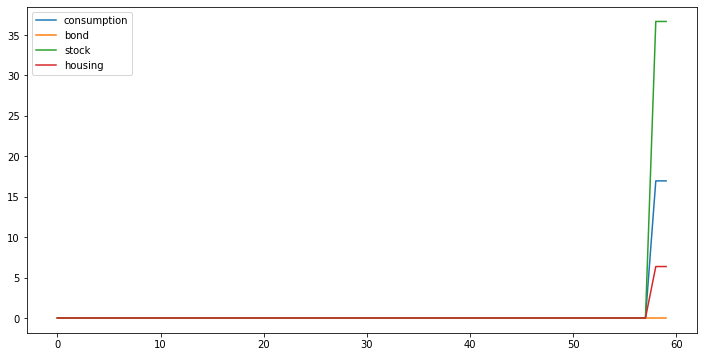

In [23]:
# plot consumption against time 
wealthLevel = 50
econState = 5
plt.figure(figsize = [12,6])
plt.plot(cgrid[wealthLevel,econState,:], label = "consumption")
plt.plot(bgrid[wealthLevel,econState,:], label = "bond")
plt.plot(kgrid[wealthLevel,econState,:], label = "stock")
plt.plot(hgrid[wealthLevel,econState,:]*pr, label = "housing")
legend()